# Homework #6: Homebrew Computer Vision

### Sam Badman - 03/23/18

## Validation Images Pathname Input 

In [1]:
# Replace pathname below with the path to the validation .jpg file directory
validation_pathname = '50_categories/airplanes/'

In [26]:
# Import all modules required in this notebook
import glob,os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
from skimage import io
from skimage.feature import corner_harris, corner_peaks,blob_log, shape_index,hog
from skimage.filters import roberts
from skimage.filters.rank import entropy
from skimage.segmentation import felzenszwalb, find_boundaries
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix as conf_mat
from multiprocessing import Pool

## Image Feature Definitions 

In [3]:
# (1) Size of the array
def arr_size(im) : return im.size

In [4]:
# (2-7) Mean and var of the image in each channel
def mean_var(im) : 
    if len(im.shape) == 2 : return np.mean(im),np.mean(im),np.mean(im),np.var(im),np.var(im),np.var(im) 
    else : return np.mean(im[:,:,0]),np.mean(im[:,:,1]),np.mean(im[:,:,2]),np.var(im[:,:,0]),np.var(im[:,:,1]),np.var(im[:,:,2])

In [5]:
# (8) Number of channels in image
def n_channels(im) :
    if len(im.shape) == 2 : return 0
    else : return im.shape[2]

In [6]:
# (9) Correlation between Red and Green Channels
def RG_corr(im) :
    if len(im.shape) == 2 : return 1.0
    else : return np.corrcoef(im[:,:,0].flatten(),im[:,:,1].flatten())[0,1]

In [7]:
# (10) Correlation between Red and Blue Channels
def RB_corr(im) :
    if len(im.shape) == 2 : return 1.0
    else : return np.corrcoef(im[:,:,0].flatten(),im[:,:,2].flatten())[0,1]

In [8]:
# (11) Correlation between Red and Green Channels
def GB_corr(im) :
    if len(im.shape) == 2 : return 1.0
    else : return np.corrcoef(im[:,:,1].flatten(),im[:,:,2].flatten())[0,1]

In [9]:
# (12),(13) Edge Pixel Count, Edge Mean
def edges(im) :
    if len(im.shape) != 2 : im = np.sum(im,axis=2) 
    edge_mask = roberts(im)
    return len(edge_mask[edge_mask > 0.2*np.max(edge_mask)]),np.mean(edge_mask)

In [10]:
# (14),(15) Number of Corners, "Amount" of corners in the image
def corners(im) :
    if len(im.shape) != 2 : im = np.sum(im,axis=2)
    ch = corner_harris(im)
    return len(corner_peaks(ch)), np.mean(np.abs(ch))

In [11]:
# (16) Number of pixels in image with larger intensity than 1/2 the max
def half_max(im) : return len(im[im > 0.5*np.max(im)])/im.size

In [12]:
# (17) Correlation between top and bottom halves of the image
def TB_corr(im) :
    if len(im.shape) != 2 : im = np.sum(im,axis=2) 
    shift = int(im.shape[1]/2)
    im_shift = np.roll(im,shift,axis=1)
    return np.corrcoef(im.flatten(),im_shift.flatten())[0,1]

In [13]:
# (18) Correlation between left and right halves of the image
def LR_corr(im) :
    if len(im.shape) != 2 : im = np.sum(im,axis=2) 
    shift = int(im.shape[0]/2)
    im_shift = np.roll(im,shift,axis=0)
    return np.corrcoef(im.flatten(),im_shift.flatten())[0,1]

In [14]:
# (19-21) shape index mean,variance and non-zeros across the image.
def shape_mean(im) :
    if len(im.shape) != 2 : im = np.sum(im,axis=2) 
    s = shape_index(im)
    result= np.mean(s),np.var(s),len(np.nonzero(s)) 
    if np.isnan(np.mean(s)) : return 0.0,0.0,0.0
    else : return result

In [15]:
# (22) Aspect Ratio
def aspect_ratio(im) : return im.shape[0]/im.shape[1]

In [16]:
# (22-24) Histogram of Gradients
def grads(image) :
    if len(image.shape) != 2 : image = np.sum(image,axis=2)
    fd = hog(image,orientations=8,visualise=False)
    return np.mean(fd),np.var(fd),len(np.nonzero(fd))

# doh - blobs , mean, var n_blobs
# hog - mean, variance, n non zero / total
# cross corr of ch with hog

__ Wrapper Function which takes input and computes all the above features for it, outputs as a single list __

In [17]:
def get_features(file_dir) :
    pathname = file_dir[1]
    im = io.imread(pathname)
    features = []
    means_vars = mean_var(im)
    edge_tup = edges(im)
    corners_tup = corners(im)
    shape_tup = shape_mean(im)
    hog_tup = grads(im)
    return ([arr_size(im),means_vars[0],means_vars[1],means_vars[2],
            means_vars[3],means_vars[4],means_vars[5],n_channels(im),
            RG_corr(im),RB_corr(im),GB_corr(im),edge_tup[0],edge_tup[1],
            corners_tup[0],corners_tup[1],half_max(im),TB_corr(im),LR_corr(im),
            shape_tup[0],shape_tup[1],shape_tup[2],aspect_ratio(im),
            hog_tup[0],hog_tup[1],hog_tup[2]] ,file_dir[0])

## Feature Extraction from Training Data

In [18]:
reprocess = False

if reprocess == True :   
    import warnings
    warnings.filterwarnings("ignore") # Suppress warnings about precision loss and divide by 0

    # Assumes the top level of the training image files '50_categories' is 
    # located in the current working directory.
    os.chdir('50_categories/')
    cats = os.listdir()
    os.chdir('../')

    file_dir = [] 
    for cat in cats : 
        if cat != '.DS_Store' : 
            for pathname in glob.glob('50_categories/'+cat+'/*.jpg') :
                file_dir.append([cat,pathname])
    t = time()            
    p = Pool(32)
    outputs = p.map(get_features,file_dir)
    X = [out[0] for out in outputs ]
    Y = [out[1] for out in outputs ]
    print("Features extracted in ",time()-t," seconds")
    
    joblib.dump((X,Y),"image_features.pkl")
    
else : X,Y = joblib.load("image_features.pkl")

## Evaluation of classifier

__ Instantiate Classifier with 10% of the training data__

In [19]:
# Instantiate Classifier Object
clf = RandomForestClassifier(n_estimators=250)

# Split images into training data and test data (90:10)
X_train,X_test,Y_train,Y_test = train_test_split(X,Y, test_size = 0.1)

# Train Classifier
clf.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

__ (1) Tabulated Prediction, True Category and True/False __

In [20]:
# Sort x_test, y_test by alphabet so different categories are grouped together
test_ind = np.argsort(Y_test)
Y_pred = clf.predict(X_test)
Y_test_sort = np.sort(Y_test)
Y_pred = Y_pred[test_ind]

total = 0
correct = 0
print("%20s %20s %20s" % ('True Category','Predicted Category','Match (True/False)'))
print("="*70)
for i in range(len(Y_test)) :
    print("%20s %20s %20s" % (Y_test_sort[i],Y_pred[i],Y_pred[i]==Y_test_sort[i]))
    correct += Y_pred[i]==Y_test_sort[i]
    total += 1

       True Category   Predicted Category   Match (True/False)
           airplanes            airplanes                 True
           airplanes            airplanes                 True
           airplanes            airplanes                 True
           airplanes            airplanes                 True
           airplanes            airplanes                 True
           airplanes            airplanes                 True
           airplanes            airplanes                 True
           airplanes            airplanes                 True
           airplanes            airplanes                 True
           airplanes            airplanes                 True
           airplanes            airplanes                 True
           airplanes            airplanes                 True
           airplanes            airplanes                 True
           airplanes            airplanes                 True
           airplanes            airplanes              

__ (2) Percentage of all test data identified correctly __

In [21]:
print("Categories identified correctly : ",correct/total *100.,' % correct')

Categories identified correctly :  32.23529411764706  % correct


This random forest classifier correctly identifies 37% of the test jpegs correctly. Compared to assigning each photograph one of the 50mcategories at random, which would be a 2% correct guess rate, we see this random forest estimator is a big improvement.

__ (3) Category by category __

The above percentage was calculated across categories but in fact some categories are identified better than others. To quantify this, we plot a confusion matrix :

In [22]:
%matplotlib inline
labs = np.unique(Y_test_sort)
cm=conf_mat(Y_test_sort,Y_pred,labels=labs)

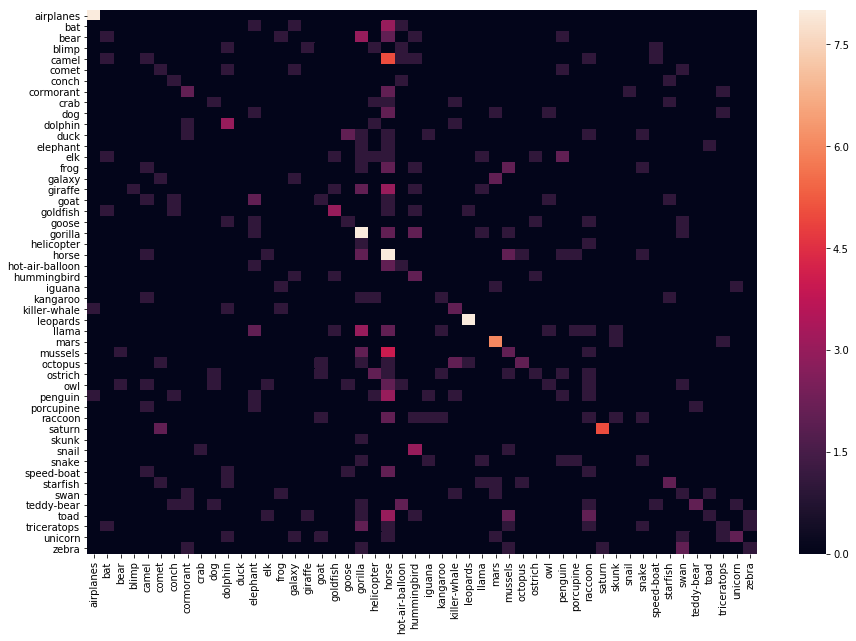

In [23]:
fig,ax = plt.subplots(figsize=(15,10))
sns.heatmap(cm, xticklabels=labs, yticklabels=labs,vmin=0,vmax=8,ax=ax)

We immediately see there is a visible diaganal trend which signals some success across most categories, however, the success is strongly peaked with specific categories, namely 'airplanes','gorillas','leopards' and 'mars'. The least successful is 'horse' which is confused with a very wide variety of the other categories. 

__ Relative importance of each feature __

Here, we rank each feature in it's importance for the decision tree generation :

In [24]:
# Name Each Feature
feature_names = [
                "Array Size","Red Mean","Green Mean","Blue Mean","Red Var",
                "Green Var","Blue Var","# Channels","Red-Green Correlation","Red-Blue Correlation",
                "Green-Blue Correlation","Edge Thresholded","Edge Mean","Number of Corners","Mean Corner Val",
                "Pixels above half max","Top-Bottom Correlation","Left-Right Correlation","Shape ind mean","Shape ind var",
                "Shape ind non-zero","Aspect Ratio","Gradient Mean","Gradient Variance","Gradient Non-zero"
                ]

feat_import = clf.feature_importances_
ind_features = np.argsort(feat_import)
features_sorted = np.array(feature_names)[ind_features]
print("%25s %25s" % ('Feature Name','Relative Importance'))
print("="*70)
for i in range(len(feature_names)) :
    print("%25s %10s %.5f" % (features_sorted[-1-i],'',np.sort(feat_import)[-1-i]))
    

             Feature Name       Relative Importance
             Aspect Ratio            0.12265
               Array Size            0.07432
        Gradient Variance            0.05629
   Left-Right Correlation            0.05554
         Edge Thresholded            0.05307
                Blue Mean            0.05041
                 Red Mean            0.04864
               Green Mean            0.04748
    Red-Green Correlation            0.04692
   Top-Bottom Correlation            0.04631
                  Red Var            0.04614
     Red-Blue Correlation            0.04573
        Number of Corners            0.04564
                 Blue Var            0.04448
   Green-Blue Correlation            0.04425
    Pixels above half max            0.04401
                Green Var            0.04377
            Shape ind var            0.03160
           Shape ind mean            0.03023
            Gradient Mean            0.01522
       Shape ind non-zero            0.00605
   

The strongest features are the aspect ratio, array size (dumb features) and the gradient and left-right correlation. The least discriminant features are the mean of the values of edge pixels, the number of channels and the number of pixels where the Histogram of Gradients is non-zero (this last one actually is not used by the random forest classifier.

## Validation of Classifer (For Grader)

In the last cell below, I have a script which takes as input the argument pathname which should be a directory pathname containing validation .jpg images. The pathname field can be edited in the very top cell of this notebook.

In [25]:
# First, retrain the classifier to use all of the available training data :
clf_all = RandomForestClassifier(n_estimators=250)
clf_all.fit(X,Y)

"""
Define function which
 - finds all jpeg files in the specified directory
 - iterates through and extracts the features from each one
 - inputs these features into the Random Forest Classifier and predicts a classification
 - prints for each jpg the filename and the predicted class
""" 
def classifier_validation(pathname,classifier) :
    print("%25s %25s" % ('filename','predicted class'))
    print("="*70)
    pathandfilenames = sorted(glob.glob(pathname+'*.jpg'))
    i = 0
    for image_path in pathandfilenames : 
        features = get_features(["",image_path])
        classification = clf.predict([features[0]])
        print("%25s %25s" % (os.path.basename(image_path),classification[0]))
        i += 1  

"""
Run function with classifier which uses all the input data
"""
classifier_validation(validation_pathname,clf_all)

                 filename           predicted class
       airplanes_0001.jpg                 airplanes
       airplanes_0002.jpg                 airplanes
       airplanes_0003.jpg                 airplanes
       airplanes_0004.jpg                 airplanes


/home/samuel_badman/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from uint64 to float64
  .format(dtypeobj_in, dtypeobj_out))
/home/samuel_badman/anaconda3/lib/python3.6/site-packages/skimage/feature/corner.py:373: RuntimeWarning: divide by zero encountered in true_divide
  return (2.0 / np.pi) * np.arctan((l2 + l1) / (l2 - l1))
/home/samuel_badman/anaconda3/lib/python3.6/site-packages/skimage/feature/corner.py:373: RuntimeWarning: invalid value encountered in true_divide
  return (2.0 / np.pi) * np.arctan((l2 + l1) / (l2 - l1))
/home/samuel_badman/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


       airplanes_0005.jpg                 airplanes
       airplanes_0006.jpg                 airplanes
       airplanes_0007.jpg                 airplanes
       airplanes_0008.jpg                 airplanes
       airplanes_0009.jpg                 airplanes
       airplanes_0010.jpg                 airplanes
       airplanes_0011.jpg                 airplanes
       airplanes_0012.jpg                 airplanes
       airplanes_0013.jpg                 airplanes
       airplanes_0014.jpg                 airplanes
       airplanes_0015.jpg                 airplanes
       airplanes_0016.jpg                 airplanes
       airplanes_0017.jpg                 airplanes
       airplanes_0018.jpg                 airplanes
       airplanes_0019.jpg                 airplanes
       airplanes_0020.jpg                 airplanes
       airplanes_0021.jpg                 airplanes
       airplanes_0022.jpg                 airplanes
       airplanes_0023.jpg                 airplanes
       airpl

       airplanes_0165.jpg                 airplanes
       airplanes_0166.jpg                 airplanes
       airplanes_0167.jpg                 airplanes
       airplanes_0168.jpg                 airplanes
       airplanes_0169.jpg                 airplanes
       airplanes_0170.jpg                 airplanes
       airplanes_0171.jpg                 airplanes
       airplanes_0172.jpg                 airplanes
       airplanes_0173.jpg                 airplanes
       airplanes_0174.jpg                 airplanes
       airplanes_0175.jpg                 airplanes
       airplanes_0176.jpg                 airplanes
       airplanes_0177.jpg                 airplanes
       airplanes_0178.jpg                 airplanes
       airplanes_0179.jpg                 airplanes
       airplanes_0180.jpg                 airplanes
       airplanes_0181.jpg                 airplanes
       airplanes_0182.jpg                 airplanes
       airplanes_0183.jpg                 airplanes
       airpl

       airplanes_0327.jpg                 airplanes
       airplanes_0328.jpg                 airplanes
       airplanes_0329.jpg                 airplanes
       airplanes_0330.jpg                 airplanes
       airplanes_0331.jpg                 airplanes
       airplanes_0332.jpg                 airplanes
       airplanes_0333.jpg                 airplanes
       airplanes_0334.jpg                 airplanes
       airplanes_0335.jpg                 airplanes
       airplanes_0336.jpg                 airplanes
       airplanes_0337.jpg                 airplanes
       airplanes_0338.jpg                 airplanes
       airplanes_0339.jpg                 airplanes
       airplanes_0340.jpg                 airplanes
       airplanes_0341.jpg                 airplanes
       airplanes_0342.jpg                 airplanes
       airplanes_0343.jpg                 airplanes
       airplanes_0344.jpg                 airplanes
       airplanes_0345.jpg                 airplanes
       airpl

       airplanes_0488.jpg                 airplanes
       airplanes_0489.jpg                 airplanes
       airplanes_0490.jpg                 airplanes
       airplanes_0491.jpg                 airplanes
       airplanes_0492.jpg                 airplanes
       airplanes_0493.jpg                 airplanes
       airplanes_0494.jpg                 airplanes
       airplanes_0495.jpg                 airplanes
       airplanes_0496.jpg                 airplanes
       airplanes_0497.jpg                 airplanes
       airplanes_0498.jpg                 airplanes
       airplanes_0499.jpg                 airplanes
       airplanes_0500.jpg                 airplanes
       airplanes_0501.jpg                 airplanes
       airplanes_0502.jpg                 airplanes
       airplanes_0503.jpg                 airplanes
       airplanes_0504.jpg                 airplanes
       airplanes_0505.jpg                 airplanes
       airplanes_0506.jpg                 airplanes
       airpl